In [1]:
# imports
%cd ..
import os
from tqdm.notebook import tqdm
from mango.environments import frozen_lake
from frozen_lake_tests import utils_plot, utils_save

c:\Users\dsart\OneDrive\Desktop\Projects\MANGO\MANGO-lite


In [2]:
# parameters for the environment
map_scale = 3
p_frozen = None

# Normal Agent

normal_agent_run_0.pickle


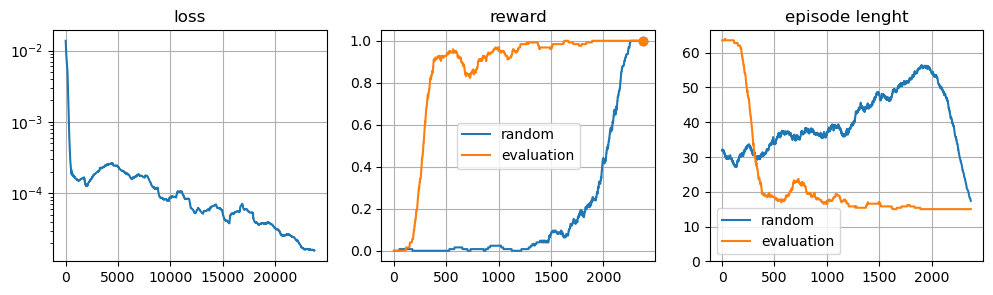

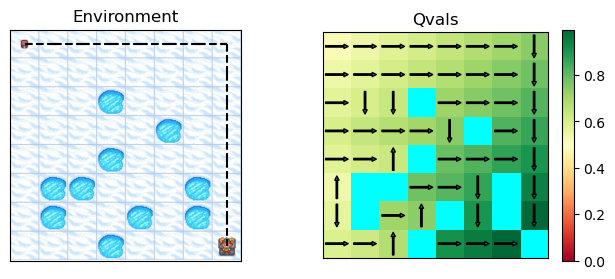

normal_agent_run_1.pickle


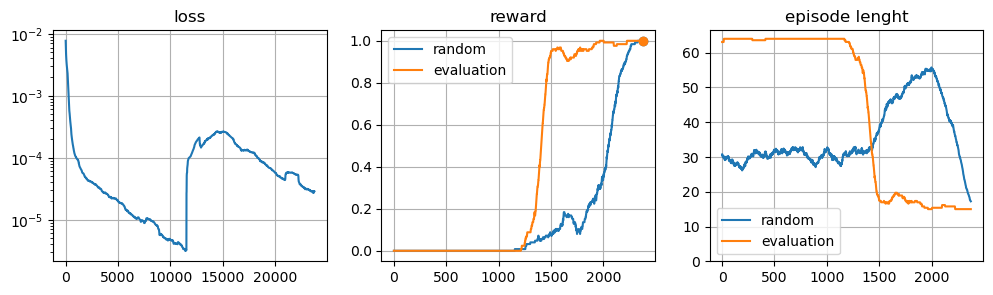

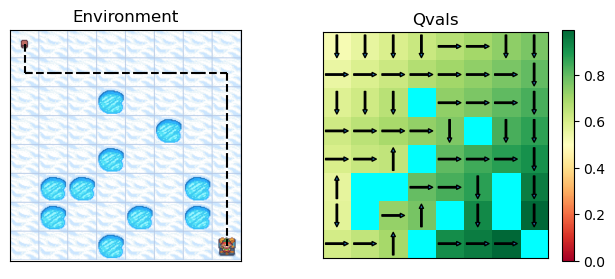

normal_agent_run_2.pickle


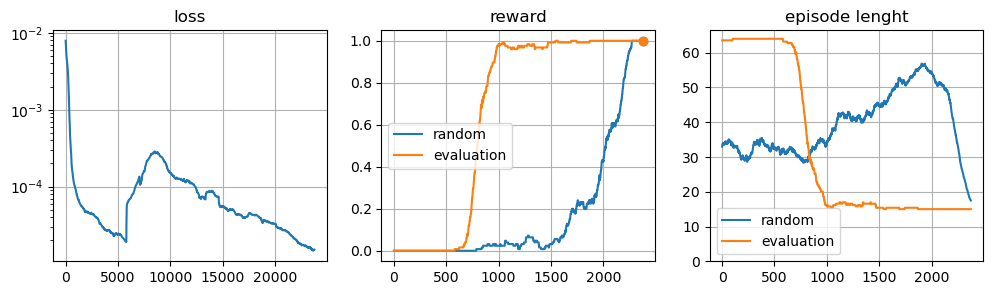

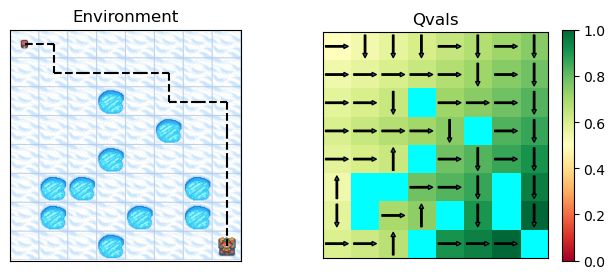

normal_agent_run_3.pickle


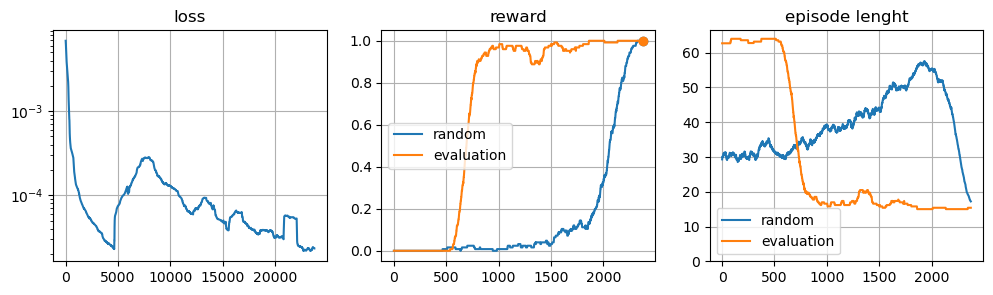

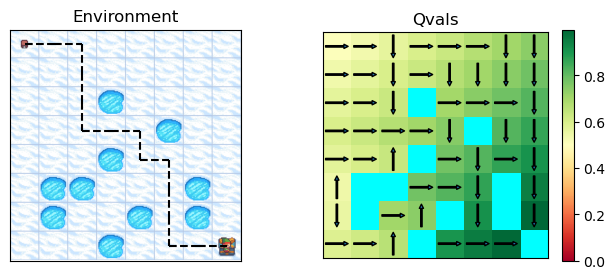

normal_agent_run_4.pickle


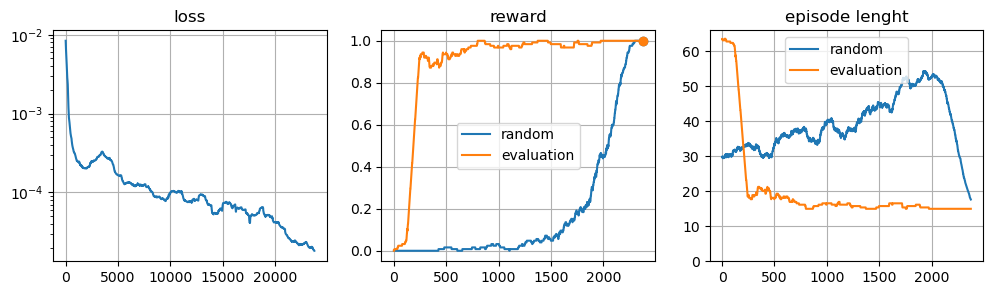

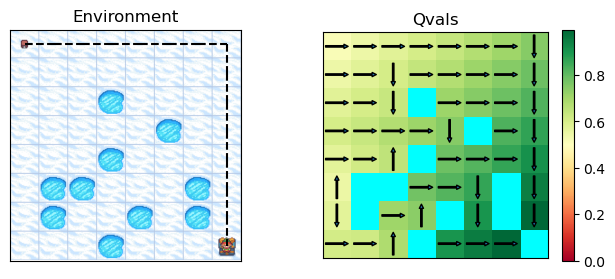

In [3]:
# load agent models one by one
dir_path = utils_save.path_to_save_dir(map_scale, p_frozen)
for filename in os.listdir(dir_path + "models/"):
    if not filename.startswith("normal_agent"):
        continue
    print(filename)
    agent = utils_save.load_from_file(dir_path + "models/" + filename)
    utils_plot.plot_normal_agent_loss_reward(agent, save_path=dir_path + f"normal_agent_training.pdf")
    agent.reset()
    trajectory, rewards = agent.run_episode(randomness=0.0, episode_length=4**map_scale)
    frozen_lake.plot_utils.plot_all_qvals_normal_agent(
        agent, trajectory, save_path=dir_path + f"normal_agent_qvals.pdf"
    )

# Mango Agent

mango_agent_run_0.pickle


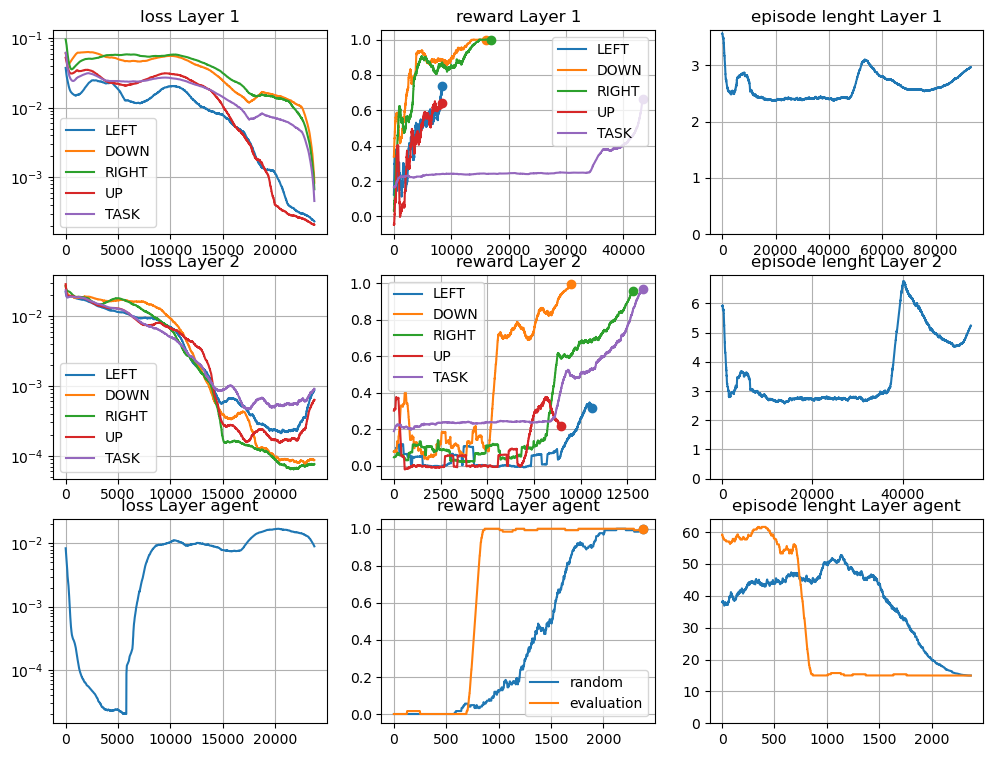

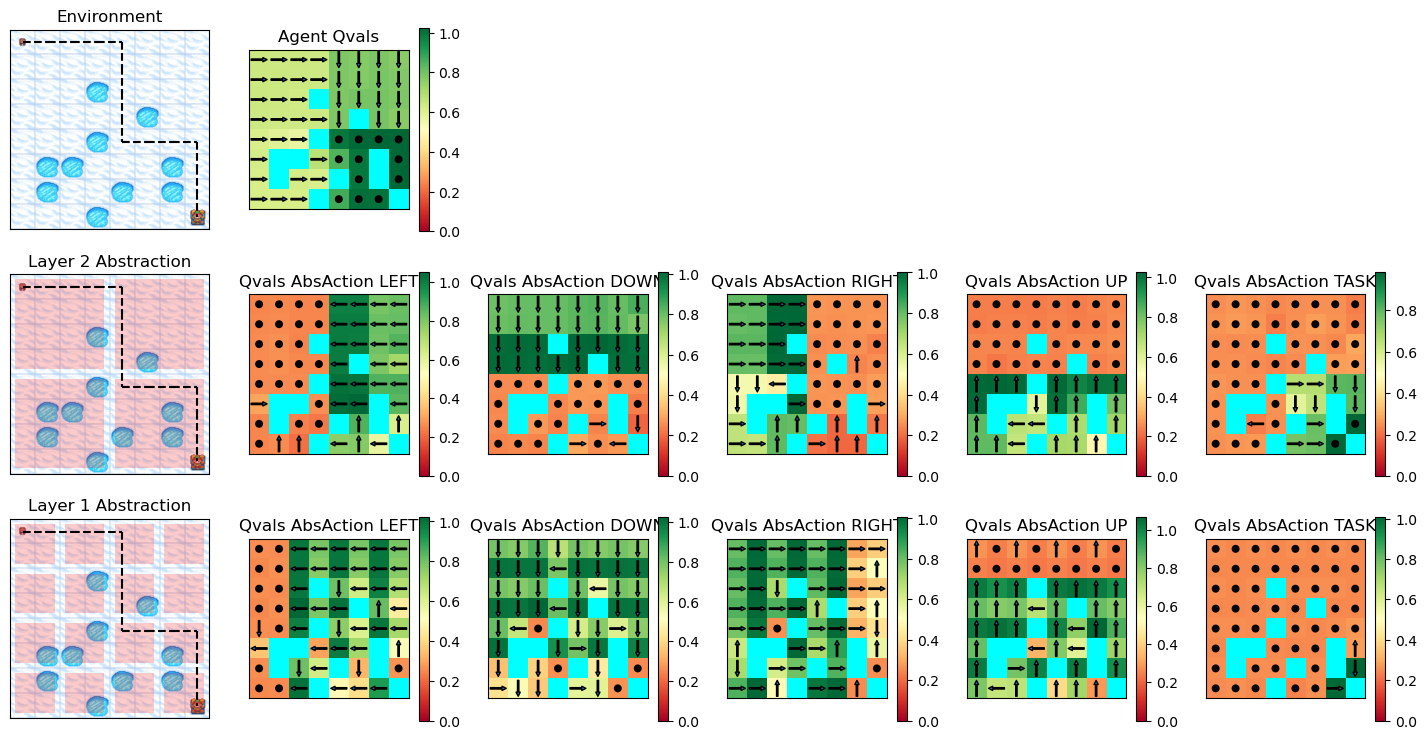

mango_agent_run_1.pickle


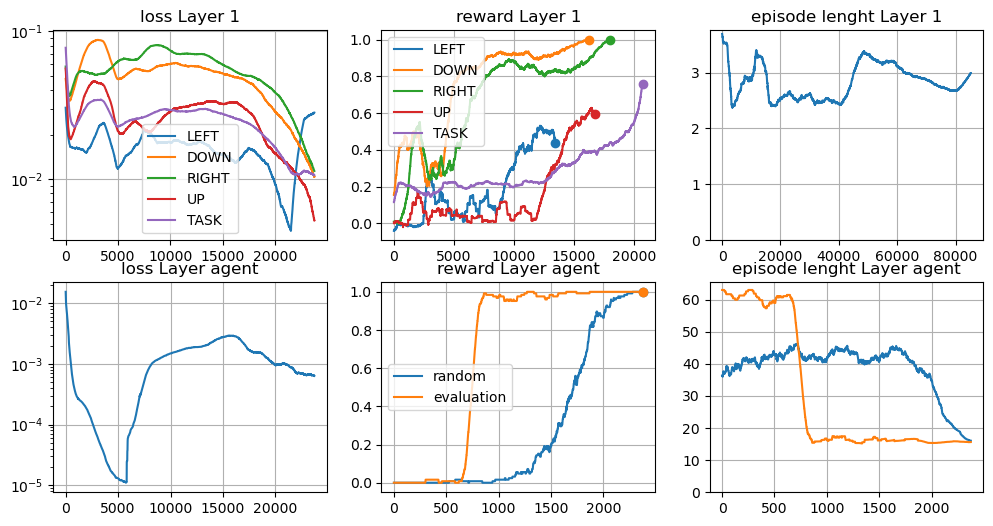

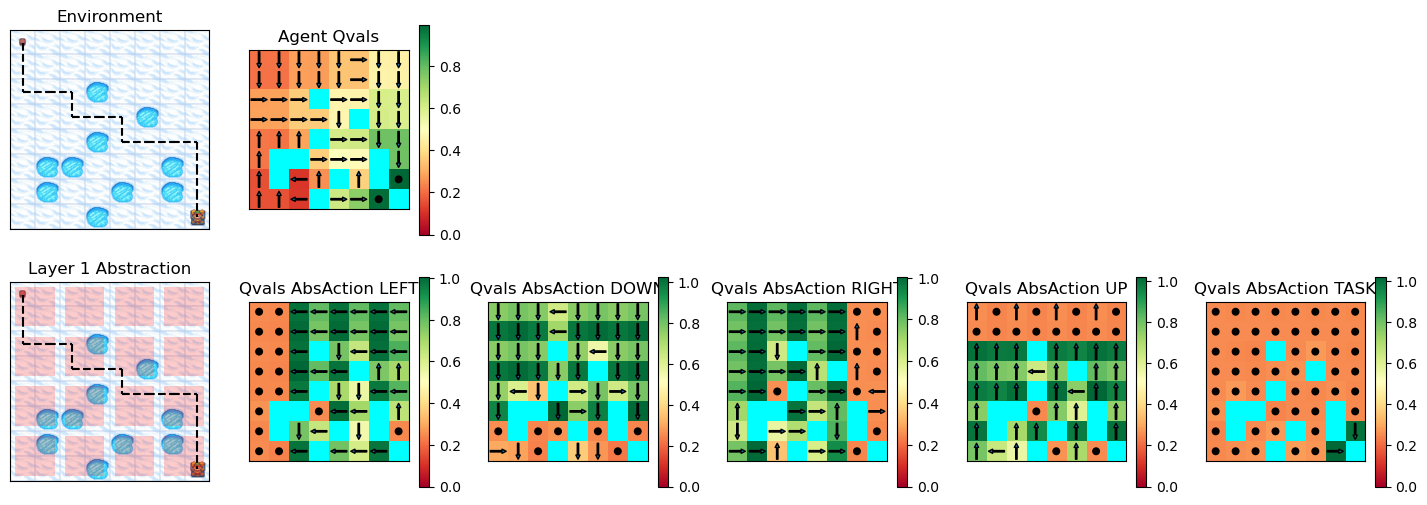

mango_agent_run_2.pickle


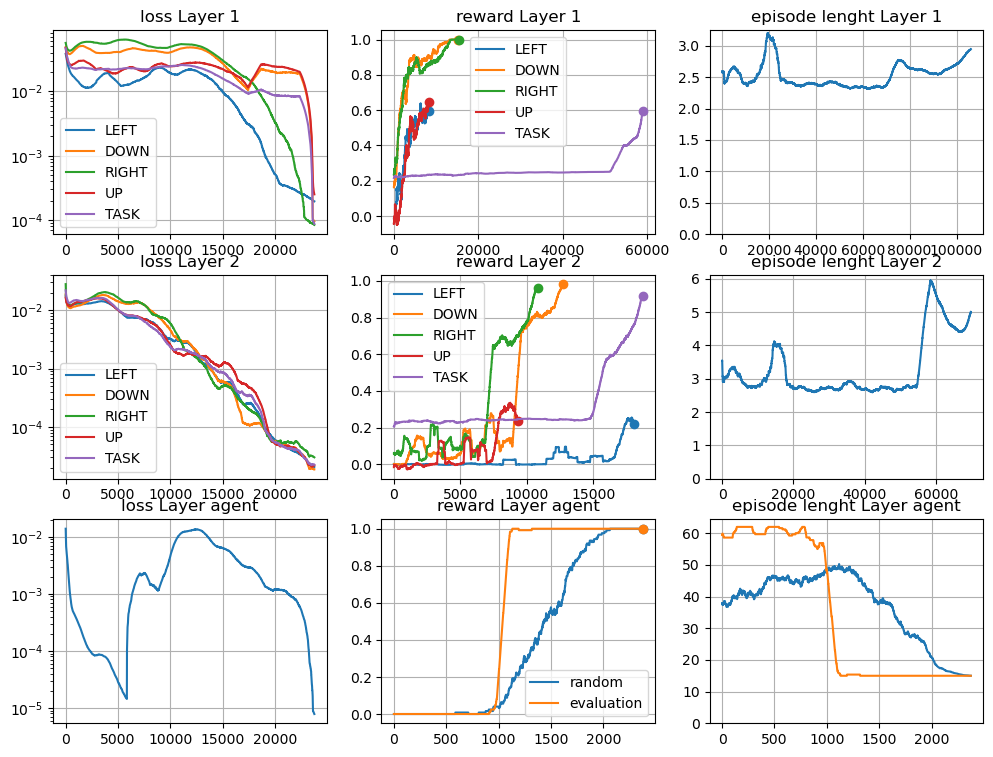

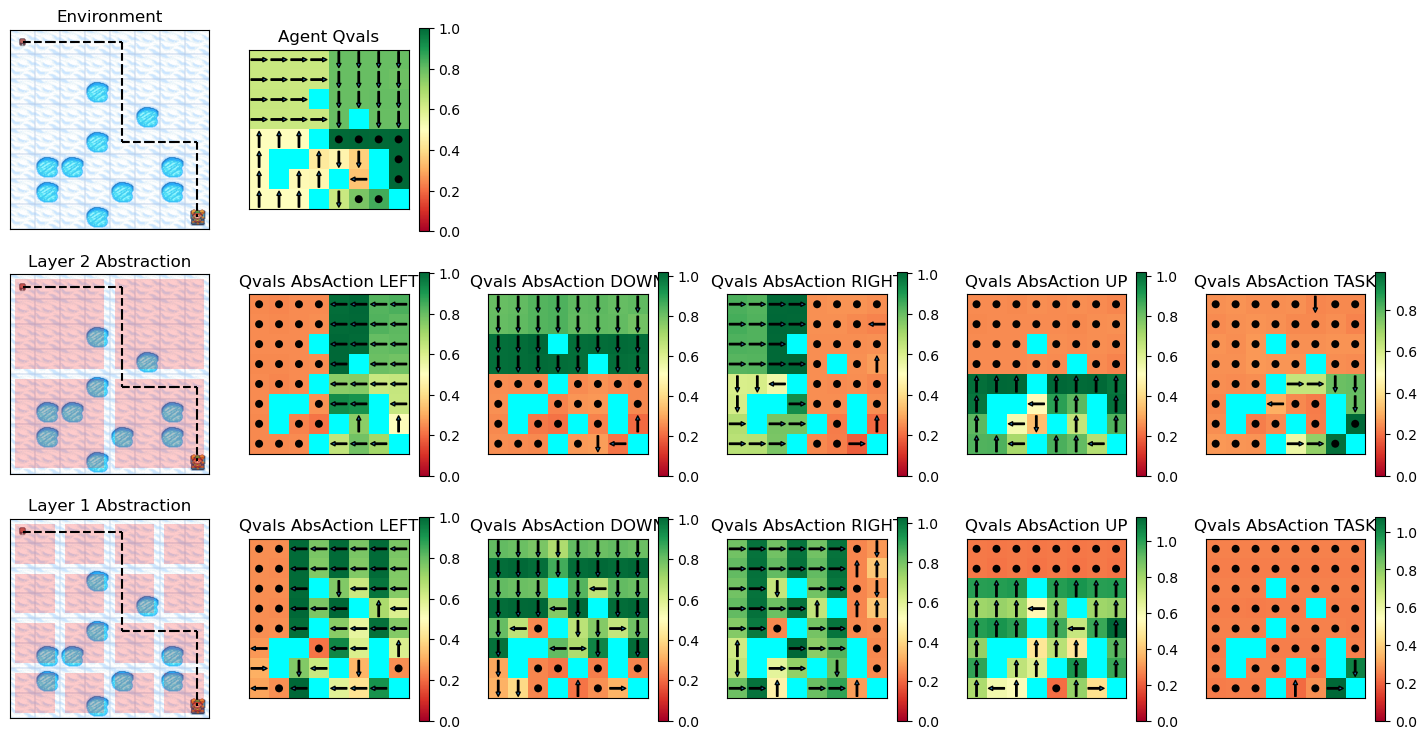

mango_agent_run_3.pickle


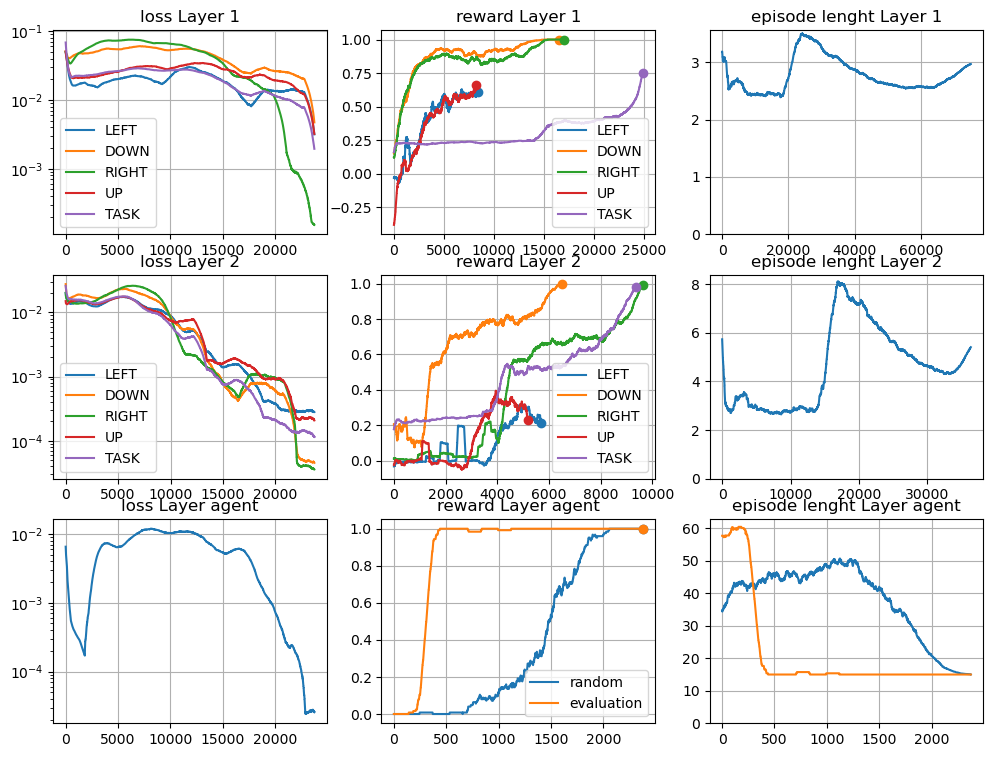

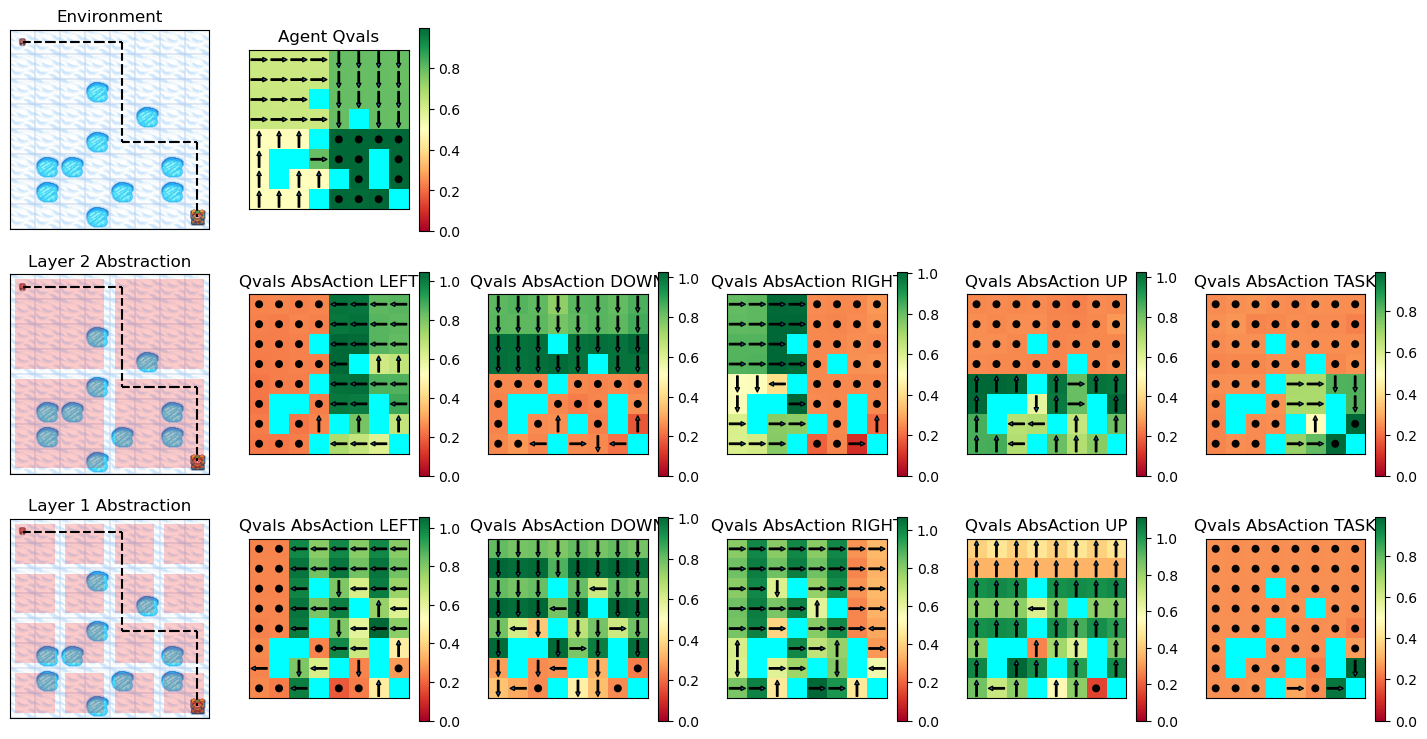

In [4]:
# load mango agent models one by one
dir_path = utils_save.path_to_save_dir(map_scale, p_frozen)
for filename in os.listdir(dir_path + "models/"):
    if not filename.startswith("mango_agent"):
        continue
    agent = utils_save.load_from_file(dir_path + "models/" + filename)
    print(filename)
    utils_plot.plot_mango_agent_loss_reward(agent, save_path=dir_path + f"mango_agent_training.pdf")
    agent.reset()
    trajectory, rewards = agent.run_episode(randomness=0.0, episode_length=4**map_scale)
    frozen_lake.plot_utils.plot_all_qvals_mango_agent(
        agent, trajectory, save_path=dir_path + f"mango_agent_qvals.pdf"
    )